In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('diabetic_data.csv')

In [2]:
data.shape

(101766, 50)

In [3]:
data.replace('?', pd.NA, inplace=True)

In [4]:

missing_values_percent = data.isna().mean() * 100

missing_values_percent[missing_values_percent > 0].sort_values(ascending=False)

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
dtype: float64

In [5]:
data = data.drop('encounter_id', axis=1)

In [6]:
data.shape

(101766, 49)

In [7]:
# Convert 'readmitted' to binary classification
def convert_readmission(value):
  if value == '<30':
    return 1
  else:
    return 0

data['readmitted'] = data['readmitted'].apply(convert_readmission)


In [8]:
display(data.iloc[12])

patient_nbr                               85504905
race                                     Caucasian
gender                                      Female
age                                        [40-50)
weight                                        <NA>
admission_type_id                                1
discharge_disposition_id                         3
admission_source_id                              7
time_in_hospital                                 7
payer_code                                    <NA>
medical_specialty           Family/GeneralPractice
num_lab_procedures                              60
num_procedures                                   0
num_medications                                 15
number_outpatient                                0
number_emergency                                 1
number_inpatient                                 0
diag_1                                         428
diag_2                                      250.43
diag_3                         

In [9]:
data['readmitted'] = data['readmitted'].astype(bool)

In [10]:
print(data.dtypes)

patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

In [11]:
near_zero_variance_cols = ['repaglinide', 'nateglinide', 'chlorpropamide', 
                           'glimepiride', 'acetohexamide', 'tolbutamide', 
                           'acarbose', 'miglitol', 'troglitazone','examide', 'citoglipton',
                           'glipizide-metformin', 'glimepiride-pioglitazone', 
                           'metformin-rosiglitazone', 'metformin-pioglitazone']

data = data.drop(near_zero_variance_cols, axis=1) 

In [12]:
data.shape

(101766, 34)

In [13]:
numerical_columns = data.select_dtypes(include=np.number)
print(numerical_columns)

        patient_nbr  admission_type_id  discharge_disposition_id  \
0           8222157                  6                        25   
1          55629189                  1                         1   
2          86047875                  1                         1   
3          82442376                  1                         1   
4          42519267                  1                         1   
...             ...                ...                       ...   
101761    100162476                  1                         3   
101762     74694222                  1                         4   
101763     41088789                  1                         1   
101764     31693671                  2                         3   
101765    175429310                  1                         1   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                         1                 1                  41   
1                         7                 3

In [14]:
for column in ['race', 'diag_1', 'diag_2', 'diag_3']:
    most_frequent = data[column].mode()[0]
    data[column].fillna(most_frequent, inplace=True)

# Re-check missing values to confirm changes
data.isna().mean().sort_values(ascending=False).head()

weight               0.968585
medical_specialty    0.490822
payer_code           0.395574
max_glu_serum        0.000000
A1Cresult            0.000000
dtype: float64

In [15]:
data.shape

(101766, 34)

In [16]:
missing_values_percent = data.isna().mean() * 100

missing_values_percent[missing_values_percent > 0].sort_values(ascending=False)

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
dtype: float64

In [17]:
data = data.drop(columns=['weight'])

In [18]:
columns_to_fill = ['medical_specialty', 'payer_code']
for column in columns_to_fill:
    data[column].fillna('Unknown', inplace=True)

# Verify changes
print(data[columns_to_fill].isna().sum())

medical_specialty    0
payer_code           0
dtype: int64


In [19]:
data.shape

(101766, 33)

In [20]:
print(numerical_columns.describe())

        patient_nbr  admission_type_id  discharge_disposition_id  \
count  1.017660e+05      101766.000000             101766.000000   
mean   5.433040e+07           2.024006                  3.715642   
std    3.869636e+07           1.445403                  5.280166   
min    1.350000e+02           1.000000                  1.000000   
25%    2.341322e+07           1.000000                  1.000000   
50%    4.550514e+07           1.000000                  1.000000   
75%    8.754595e+07           3.000000                  4.000000   
max    1.895026e+08           8.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count        101766.000000     101766.000000       101766.000000   
mean              5.754437          4.395987           43.095641   
std               4.064081          2.985108           19.674362   
min               1.000000          1.000000            1.000000   
25%               1.000000          2.000000   

In [21]:
data['admission_type_id']=data['admission_type_id'].apply(lambda x : 5 if x in (6,8) else x)
data['admission_type_id']=data['admission_type_id'].apply(lambda x : 1 if x == 4 else 2 if x==7 else x )

In [22]:
#Discharged Home: 1, 6, 8
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 1 if x in (6,8) else x)

#Uncategorized/Unknown: 18, 25, 26, 12
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 18 if x in (25,26,12) else x)

#Expired:11, 19, 20, 21
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 11 if x in (19,20,21) else x)

#Hospice:13, 14
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 13 if x ==14 else x)

# Discharged/Transferred to Hospital: 2, 9, 10, 23, 27, 28, 29
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 2 if x in ( 9, 10, 23, 27, 28, 29) else x)

#Discharged/Transferred to Care Facility: 3, 4, 5, 15, 24
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 3 if x in ( 4, 5, 15, 24) else x)

#Discharged to Outpatient Services:16, 17
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 16 if x ==17 else x)

In [23]:
data['admission_source_id']= data['admission_source_id'].apply(lambda x : 9 if x in (15, 17, 20, 21) else x)

# Physician/Clinic Referral:1, 2, 3
data['admission_source_id']= data['admission_source_id'].apply(lambda x : 1 if x in (2,3) else x)

#Transfer from Hospital: 4, 10, 22
data['admission_source_id']= data['admission_source_id'].apply(lambda x : 4 if x in (10,22) else x)


#Transfer from Facility:5, 6, 18, 19, 25, 26
data['admission_source_id']= data['admission_source_id'].apply(lambda x : 5 if x in (6, 18, 19, 25, 26) else x)

#Delivery:11, 12, 13, 14
data['admission_source_id']= data['admission_source_id'].apply(lambda x : 11 if x in (12, 13, 14) else x)

In [24]:
data.shape

(101766, 33)

In [25]:
# all three diag features have more than 700 unqie we are grouping them based on ICD-9 codes
diag1_list=[]
diag2_list=[]
diag3_list=[]

In [26]:
def diag_cluster(col, diag_list):
    for x in data[col]:
        # If the value in the 'col' column contains 'V' or 'E', it is assigned a cluster value of 18.
        if 'V' in x or 'E' in x: 
            diag_list.append(18)
            continue
        # The following conditions assign cluster values based on specific ranges of float values.
        elif 1 <= float(x) <= 139:
            diag_list.append(1)
        elif 140 <= float(x) <= 239:
            diag_list.append(2)
        elif 240 <= float(x) <= 279:
            diag_list.append(3)
        elif 280 <= float(x) <= 289:
            diag_list.append(4)
        elif 290 <= float(x) <= 319:
            diag_list.append(5)
        elif 320 <= float(x) <= 389:
            diag_list.append(6)
        elif 390 <= float(x) <= 459:
            diag_list.append(7)
        elif 460 <= float(x) <= 519:
            diag_list.append(8)
        elif 520 <= float(x) <= 579:
            diag_list.append(9)
        elif 580 <= float(x) <= 629:
            diag_list.append(10)
        elif 630 <= float(x) <= 679:
            diag_list.append(11)
        elif 680 <= float(x) <= 709:
            diag_list.append(12)
        elif 710 <= float(x) <= 739:
            diag_list.append(13)
        elif 740 <= float(x) <= 759:
            diag_list.append(14)
        elif 760 <= float(x) <= 779:
            diag_list.append(15)
        elif 780 <= float(x) <= 799:
            diag_list.append(16)
        elif 800 <= float(x) <= 999:
            diag_list.append(17)

In [27]:
diag_cluster('diag_1',diag1_list)
diag_cluster('diag_2',diag2_list)
diag_cluster('diag_3',diag3_list)

In [28]:
data['diag_1']=diag1_list
data['diag_2']=diag2_list
data['diag_3']=diag3_list

In [29]:
data.shape

(101766, 33)

In [30]:
data.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                       int64
diag_2                       int64
diag_3                       int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
glipizide                   object
glyburide                   object
pioglitazone                object
rosiglitazone               object
tolazamide                  object
insulin             

In [31]:
data['change']=data['change'].apply(lambda x: 'Yes' if x=='Ch' else x)

In [32]:
medicines = ['metformin',   'glipizide', 'glyburide',  'pioglitazone', 'rosiglitazone',  'insulin']

for col in medicines:
    data[col] = data[col].apply(lambda x: 0 if x == 'No' else 1)

In [33]:
data['gender']=data['change'].apply(lambda x: 0 if x=='Female' else 1)

In [34]:
data['change']=data['change'].apply(lambda x : 0 if x=='No' else 1)
data['diabetesMed']=data['diabetesMed'].apply(lambda x : 0 if x=='No' else 1)

In [35]:
data.drop_duplicates(subset='patient_nbr',keep='first',inplace=True)

In [36]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
data['race']=encoder.fit_transform(data['race'])

In [37]:
data.shape

(71518, 33)

In [38]:
numerical_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses']

outliers_percentage = {}

# Iterate over numerical columns
for column in numerical_columns:
    # Calculate Z-Score Method outliers
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    outliers_zscore = (z_scores > 3)
    
    # Calculate percentage of outliers
    total_outliers = outliers_zscore.sum()
    total_count = len(data)
    percentage = (total_outliers / total_count) * 100
    
    outliers_percentage[column] = percentage

# Print percentage of outliers for each column
print("Percentage of outliers in each column using Z-score method:")
for column, percentage in outliers_percentage.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each column using Z-score method:
time_in_hospital: 0.94%
num_lab_procedures: 0.05%
num_procedures: 0.00%
num_medications: 1.50%
number_outpatient: 1.81%
number_emergency: 1.73%
number_inpatient: 3.47%
number_diagnoses: 0.33%


In [39]:
# # Identify numerical columns
# numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# # Create box plots for each numerical feature
# plt.figure(figsize=(20, 15))
# for i, col in enumerate(numerical_columns, 1):
#     plt.subplot(5, 4, i)
#     sns.boxplot(y=data[col])
#     plt.title(col)

# plt.tight_layout()
# plt.show()

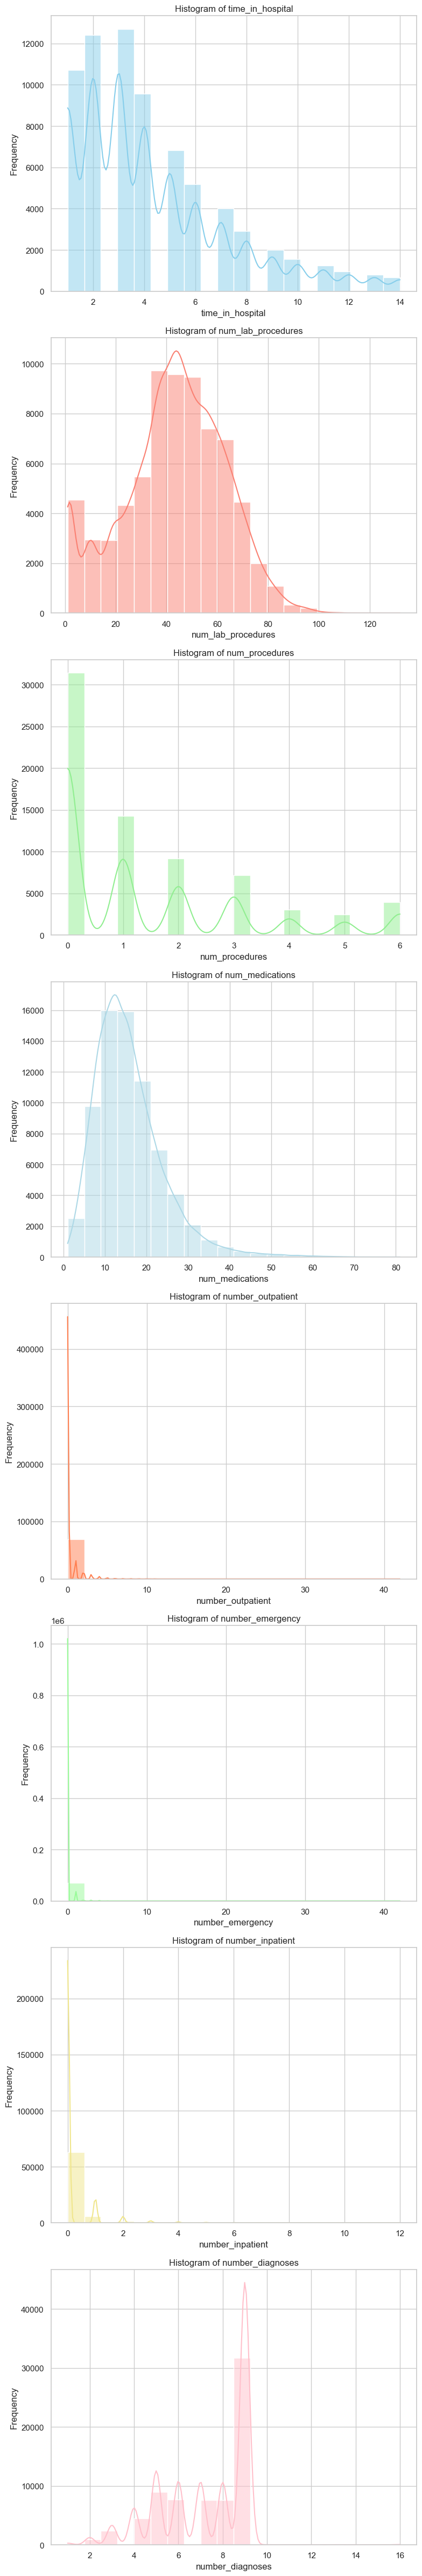

In [40]:
# Setting the seaborn style for the plots
sns.set(style="whitegrid")

# Create a figure and axis to plot histograms for multiple features
fig, axs = plt.subplots(8, 1, figsize=(8, 48))  # Adjusted for the number of variables

# List of features to plot
features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# Colors for the plots
colors = [
    'skyblue', 'salmon', 'lightgreen', 'lightblue', 'coral', 'palegreen',
    'khaki', 'pink', 'lightgrey', 'cyan', 'peachpuff', 'lavender'
]

# Loop through features and create histograms
for i, feature in enumerate(features):
    sns.histplot(data=data, x=feature, bins=20, kde=True, color=colors[i], ax=axs[i])
    axs[i].set_title(f'Histogram of {feature}')
    axs[i].set_xlabel(f'{feature}')
    axs[i].set_ylabel('Frequency')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [41]:
data.shape

(71518, 33)

In [42]:
# # Setting the seaborn style for the plots
# sns.set(style="whitegrid")

# # Create a figure and axis to plot histograms for multiple features
# fig, axs = plt.subplots(12, 1, figsize=(8, 48))  # Adjusted for the number of variables

# # List of features to plot
# features = [
#     'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#     'time_in_hospital', 'num_lab_procedures', 'num_procedures',
#     'num_medications', 'number_outpatient', 'number_emergency',
#     'number_inpatient', 'number_diagnoses'
# ]

# # Colors for the plots
# colors = [
#     'skyblue', 'salmon', 'lightgreen', 'lightblue', 'coral', 'palegreen',
#     'khaki', 'pink', 'lightgrey', 'cyan', 'peachpuff', 'lavender'
# ]

# # Loop through features and create histograms
# for i, feature in enumerate(features):
#     sns.histplot(data=data1, x=feature, bins=20, kde=True, color=colors[i], ax=axs[i])
#     axs[i].set_title(f'Histogram of {feature}')
#     axs[i].set_xlabel(f'{feature}')
#     axs[i].set_ylabel('Frequency')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()


In [43]:

# Initialize a new dataframe to store cleaned data
diabetic_data_outliers_handled = data.copy()

# List of features to apply Z-score method
z_score_features = ['num_lab_procedures', 'num_medications', ]  # Assuming normal distribution

# List of features to apply IQR method
iqr_features = ['time_in_hospital', 'num_procedures', 'number_outpatient','number_diagnoses', 'number_emergency', 'number_inpatient']

# Apply Z-score method for assumed normal distribution features
for feature in z_score_features:
    z_scores = np.abs(stats.zscore(diabetic_data_outliers_handled[feature]))
    filtered_entries = (z_scores < 3)  # Filtering out data points that are more than 3 standard deviations away
    diabetic_data_outliers_handled = diabetic_data_outliers_handled[filtered_entries]

# Apply IQR method for skewed distribution features
for feature in iqr_features:
    Q1 = diabetic_data_outliers_handled[feature].quantile(0.25)
    Q3 = diabetic_data_outliers_handled[feature].quantile(0.75)
    IQR = Q3 - Q1
    filtered_entries = ((diabetic_data_outliers_handled[feature] >= (Q1 - 2.5 * IQR)) & 
                        (diabetic_data_outliers_handled[feature] <= (Q3 + 2.5 * IQR)))
    diabetic_data_outliers_handled = diabetic_data_outliers_handled[filtered_entries]

# Calculate the final size of the dataset after outlier handling
final_data_size_outliers_handled = len(diabetic_data_outliers_handled) / len(data) * 100

final_data_size_outliers_handled


72.68799463072233

In [44]:
diabetic_data_outliers_handled.shape


(51985, 33)

In [45]:
diabetic_data_modified_outliers = data.copy()

# Apply modified IQR method for skewed distribution features with a less strict range
for feature in iqr_features:
    Q1 = diabetic_data_modified_outliers[feature].quantile(0.25)
    Q3 = diabetic_data_modified_outliers[feature].quantile(0.75)
    IQR = Q3 - Q1
    filtered_entries = ((diabetic_data_modified_outliers[feature] >= (Q1 - 2.5 * IQR)) & 
                        (diabetic_data_modified_outliers[feature] <= (Q3 + 2.5 * IQR)))
    diabetic_data_modified_outliers = diabetic_data_modified_outliers[filtered_entries]

# Calculate the final size of the dataset after modified outlier handling
final_data_size_modified_outliers = len(diabetic_data_modified_outliers) / len(data) * 100

final_data_size_modified_outliers

73.92264884364775

In [46]:
diabetic_data_modified_outliers.shape

(52868, 33)

In [47]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select numerical columns for normalization
numerical_columns = diabetic_data_modified_outliers.select_dtypes(include=['int64', 'float64']).columns

# Apply Min-Max normalization
diabetic_data_modified_outliers[numerical_columns] = scaler.fit_transform(diabetic_data_modified_outliers[numerical_columns])


In [48]:
diabetic_data_modified_outliers.shape

(52868, 33)

In [49]:
diabetic_data_modified_outliers.to_csv("cleaned_imp75k.csv", index=False)

In [50]:
categorical_features = ['diag_3', 'diag_1', 'age', 'diag_2', 'race', 'admission_type_id', 
                        'discharge_disposition_id', 'insulin', 'diabetesMed', 'change', 
                        'metformin', 'glipizide', 'glyburide', 'rosiglitazone', 'pioglitazone']
numerical_features = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 
                      'number_diagnoses', 'num_procedures', 'admission_source_id', 
                      'number_outpatient', 'number_inpatient', 'number_emergency']


In [51]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder( drop='first')



In [52]:
# Fit and transform the categorical features
X_categorical_encoded = encoder.fit_transform(diabetic_data_modified_outliers[categorical_features]).toarray()

# Create a DataFrame for the encoded features, using the get_feature_names_out method for column names
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, 
                                        columns=encoder.get_feature_names_out(categorical_features))


In [53]:

X_numerical = diabetic_data_modified_outliers[numerical_features].reset_index(drop=True)
X_categorical_encoded_df = X_categorical_encoded_df.reset_index(drop=True)

# Concatenate the numerical features and the encoded categorical features
X_encoded = pd.concat([X_numerical, X_categorical_encoded_df], axis=1)

y=diabetic_data_modified_outliers['readmitted']

In [54]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_res, y_res = sm.fit_resample(X_encoded, y)

C:\Users\bhuva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

In [56]:
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import catboost
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        boosting_type= trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        bootstrap_type=trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "MVS"]
        ),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        #bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        #max_leaves=trial.suggest_int("max_leaves",15,40),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf",51,120),
        loss_function='Logloss',
        eval_metric='Logloss',
        task_type='GPU',
        verbose=False,
    )
    model.fit(X_train, y_train,eval_set=[(X_test,y_test)])
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred,average='micro')

C:\Users\bhuva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
params={'iterations': 881, 'learning_rate': 0.01961057467284439, 'depth': 10, 'l2_leaf_reg': 0.0026174150623770134, 'bootstrap_type': 'Bayesian', 'random_strength': 2.191236365450965e-06, 'bagging_temperature': 5.6475486877966965, 'od_type': 'IncToDec', 'od_wait': 42}

In [58]:
model=catboost.CatBoostClassifier(**params,verbose=False)


In [59]:
model.fit(X_train,y_train)

In [60]:
probs=model.predict_proba(X_test)


In [61]:
y_pred=model.predict(X_test)


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12248
        True       1.00      0.92      0.95     12129

    accuracy                           0.96     24377
   macro avg       0.96      0.96      0.96     24377
weighted avg       0.96      0.96      0.96     24377

